<div style="display: flex; align-items: center; justify-content: space-between">
    <div>
        <img src="https://raw.githubusercontent.com/sebastianVP/RADAR_AMISR/refs/heads/main/igp_logo.jpeg"
         alt="LOGO IGP" width="200" height="200" style="margin-left: 20px; border-radius: 10px;" align = "right">
        <h1 style="color: #800020;  font-weight: bold; margin-bottom: 10px; font-family: Arial, sans-serif;">
          <font color="#7F000E">
            Maestría de Ciencias de la Computación UNI-IGP
          </font>
        </h1>
        <h2 style="color: #800020;font-weight: bold; max-width: 750px; font-family: Arial, sans-serif;">
          <strong><font color="#7F000E" size=5 >
            Desarrollo de sistema de pronóstico de centelleo ionosférico sobre el Perú para alerta de
            perturbaciones en señales satelitales
          </font ></strong>
        </h2>
    </div>
</div>
<div>
    <p style="margin-bottom: 5px;">
    <strong>
    <font color="#7F000E" size=3 > N1-MODULO DE PROCESAMIENTO PARA CINTILACIONES IONOFÉRICAS </strong></p>
    <p style="margin-bottom: 5px;">
    <font color="#7F000E"><strong>Alumno:</strong></font>
    <font color="#7F000E"> Alexander Valdez Portocarrero</p>
    <p style="margin-bottom: 5px;">
    <font color="#7F000E"><strong>Código:</strong> 20207072E</p>
    <p style="margin-bottom: 5px;">
    <font color="#7F000E"><strong>Fecha:</strong>  23/12/2025</p>
    <p style="margin-bottom: 5px;">
    <font color="#7F000E"><strong> Ciclo 2025-2</strong></p>
</div>

---

# **MONTAR DISCO DRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **0. LIBRERIAS**

In [2]:
# =============================================================================
# MODULO DE PREPROCESAMIENTO PARA CINTILACIONES IONOSFÉRICAS
# Autor: Alexander Valdez Portocarrero
# Descripción: Carga, análisis exploratorio y preparación de tensores para LSTM
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf # Solo si necesitas verificar GPU aquí
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Importaciones específicas de Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# **1. CARGA DE DATOS**

In [3]:
def cargar_dataset(path, filename):
    """
    Carga el CSV y realiza la conversión inicial de fechas.
    """
    full_path = os.path.join(path, filename)

    if not os.path.exists(full_path):
        raise FileNotFoundError(f"No se encontró el archivo en: {full_path}")

    print(f"📂 Cargando archivo: {filename}...")
    df = pd.read_csv(full_path)

    # Conversión única y definitiva a datetime
    df["Tiempo"] = pd.to_datetime(df["Tiempo"])

    # Ordenar cronológicamente (vital para series temporales)
    df = df.sort_values("Tiempo")

    print(f"✅ Dataset cargado. Shape: {df.shape}")
    print(f"   Rango de fechas: {df['Tiempo'].min()} a {df['Tiempo'].max()}")
    return df

# **2. ANALISIS EXPLORATORIO(EDA)**

In [5]:
def analizar_eventos_cintilacion(df, umbral_s4=0.6, plot=True):
    """
    Analiza y visualiza los días con presencia de cintilación.
    No modifica el DF original permanentemente, solo reporta estadísticas.
    """
    print("\n🔍 Analizando distribución de eventos...")

    # Trabajamos con una copia ligera para no alterar el original
    df_analisis = df[["Tiempo", "S4"]].copy()
    df_analisis["Fecha"] = df_analisis["Tiempo"].dt.date

    # 1. Identificar si cada día superó el umbral
    resumen_diario = df_analisis.groupby("Fecha")["S4"].max() > umbral_s4
    resumen_diario = resumen_diario.reset_index()
    resumen_diario.columns = ["Fecha", "Evento_Cintilacion"] # True/False

    total_dias = resumen_diario["Fecha"].nunique()
    dias_con_evento = resumen_diario["Evento_Cintilacion"].sum()

    print(f"   Total de días registrados: {total_dias}")
    print(f"   Días con eventos (S4 > {umbral_s4}): {dias_con_evento}")
    print(f"   Porcentaje de actividad: {(dias_con_evento/total_dias)*100:.2f}%")

    # 2. Reporte Mensual
    df_analisis["Mes"] = df_analisis["Tiempo"].dt.to_period("M")

    # Unimos para saber qué día tuvo evento
    # Primero agrupamos por día para saber si ESE día hubo evento
    max_s4_dia = df_analisis.groupby(["Mes", "Fecha"])["S4"].max().reset_index()
    max_s4_dia["Tuvo_Evento"] = (max_s4_dia["S4"] > umbral_s4).astype(int)

    # Tabla resumen
    tabla_mensual = max_s4_dia.groupby("Mes")["Tuvo_Evento"].agg(
        Dias_Con_Cintilacion='sum',
        Total_Dias='count'
    )
    tabla_mensual["Dias_Sin_Cintilacion"] = tabla_mensual["Total_Dias"] - tabla_mensual["Dias_Con_Cintilacion"]

    print("\n📊 Resumen Mensual de Actividad:")
    print(tabla_mensual)

    # 3. Visualización (Opcional)
    if plot:
        plt.figure(figsize=(12, 5))
        # Convertimos a string para que matplotlib no haga lío con fechas
        fechas_str = resumen_diario["Fecha"].astype(str)
        valores = resumen_diario["Evento_Cintilacion"].astype(int)

        plt.bar(fechas_str, valores, color=np.where(valores==1, 'orange', 'skyblue'))
        plt.title(f"Días con Cintilación (S4 > {umbral_s4})")
        plt.ylabel("Presencia (1=Sí, 0=No)")
        plt.xticks(rotation=90, fontsize=8)

        # Mostrar solo una etiqueta cada 7 días para no saturar
        ax = plt.gca()
        for index, label in enumerate(ax.xaxis.get_ticklabels()):
            if index % 7 != 0:
                label.set_visible(False)

        plt.tight_layout()
        plt.show()

# **3. FEATURE ENGINEERING**

In [6]:
# =============================================================================
# 3. INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING)
# =============================================================================
def agregar_caracteristicas_temporales(df):
    """
    Agrega transformaciones cíclicas de tiempo (Seno/Coseno).
    """
    print("\n⚙️ Generando características temporales (Sin/Cos)...")

    # Calcular minuto del día (0–1439)
    minutos_dia = df["Tiempo"].dt.hour * 60 + df["Tiempo"].dt.minute
    periodo = 24 * 60 # 1440 minutos

    # Transformación
    df["Hora_Sin"] = np.sin(2 * np.pi * minutos_dia / periodo)
    df["Hora_Cos"] = np.cos(2 * np.pi * minutos_dia / periodo)

    return df


# **4. PREPARACIÓN FINAL DE ESTRUCTURA**

In [7]:
def finalizar_estructura_df(df, target_col="S4"):
    """
    Limpia columnas auxiliares, reordena y establece el índice temporal.
    Esta función deja el DF listo para entrar al Generador de Ventanas.
    """
    print("\n🧹 Finalizando estructura del DataFrame...")

    # 1. Asegurar índice temporal
    if df.index.name != 'Tiempo':
        df = df.set_index('Tiempo')

    df = df.sort_index()

    # 2. Reordenar columnas: Target al final (práctica estándar)
    cols = [c for c in df.columns if c != target_col]
    cols.append(target_col)
    df = df[cols]

    # 3. Eliminar columnas que ya no sirven para el modelo numérico
    # (Ej: Fechas string, columnas categóricas, etc.)
    cols_a_borrar = ["dias", "Fecha", "Mes", "minuto_del_dia", "Cintilacion"]
    # Borramos solo si existen
    cols_existentes = [c for c in cols_a_borrar if c in df.columns]

    if cols_existentes:
        df = df.drop(columns=cols_existentes)
        print(f"   Columnas eliminadas: {cols_existentes}")

    print(f"✅ DataFrame Final Listo. Shape: {df.shape}")
    print(f"   Columnas finales: {df.columns.tolist()}")

    return df

# **5. ESTRATEGIA DE DIVISIÓN DE DATOS -DATASPLITTING**

In [8]:
# =============================================================================
# 5. ESTRATEGIA DE DIVISIÓN DE DATOS (DATA SPLITTING)
# =============================================================================
def dividir_estratificado_por_dias(df, umbral_s4=0.6):
    """
    Divide el dataset asegurando que haya días con tormentas en Train, Val y Test.
    """
    print("\n✂️ Ejecutando división estratificada de datos...")

    # Trabajamos con copia para no afectar el original
    temp_df = df.copy()

    # Si la columna Fecha no existe (porque la borramos en el paso 4), la recuperamos del índice
    if 'Fecha' not in temp_df.columns:
        temp_df['Fecha'] = temp_df.index.date

    # 1. Identificar Días Activos vs Días Quietos
    resumen_diario = temp_df.groupby('Fecha')['S4'].max().reset_index()

    dias_activos = resumen_diario[resumen_diario['S4'] > umbral_s4]['Fecha'].values
    dias_quietos_original = resumen_diario[resumen_diario['S4'] <= umbral_s4]['Fecha'].values
    #dias_quietos = resumen_diario[resumen_diario['S4'] <= umbral_s4]['Fecha'].values

    #------ AQUI VAMOS A MODIFICAR--------#
    n_activos = len(dias_activos)
    dias_quietos = dias_quietos_original[:n_activos]
    #dias_quietos = resumen_diario[resumen_diario['S4'] <= umbral_s4]['Fecha'].values
    #--------------------------------------------------------------------------------

    print(f"   Total Días Activos encontrados: {len(dias_activos)}")
    print(f"   Total Días Quietos encontrados: {len(dias_quietos)}")

    # 2. Repartir los Días ACTIVOS (aprox 70/15/15)
    # Primero separamos Train (70%) del resto (30%)
    activos_train, activos_temp = train_test_split(dias_activos, test_size=0.3, random_state=42)
    # Luego separamos ese resto en Val (50% del resto) y Test (50% del resto)
    activos_val, activos_test = train_test_split(activos_temp, test_size=0.5, random_state=42)

    # 3. Repartir los Días QUIETOS (misma lógica)
    quietos_train, quietos_temp = train_test_split(dias_quietos, test_size=0.3, random_state=42)
    quietos_val, quietos_test = train_test_split(quietos_temp, test_size=0.5, random_state=42)

    # 4. Combinar las listas
    lista_dias_train = np.concatenate([activos_train, quietos_train])
    lista_dias_val = np.concatenate([activos_val, quietos_val])
    lista_dias_test = np.concatenate([activos_test, quietos_test])

    # 5. Crear los DataFrames Finales
    # Ordenamos por fecha para mantener la lógica temporal interna
    # NOTA: Usamos temp_df['Fecha'] para filtrar, pero devolvemos df (el original limpio)
    #       Para asegurar consistencia, filtramos temp_df y luego dropeamos 'Fecha' si fue agregada,
    #       o simplemente usamos el índice.

    # Filtrar usando las fechas
    train = temp_df[temp_df['Fecha'].isin(lista_dias_train)].sort_index()
    val = temp_df[temp_df['Fecha'].isin(lista_dias_val)].sort_index()
    test = temp_df[temp_df['Fecha'].isin(lista_dias_test)].sort_index()

    # Limpieza final: Si agregamos 'Fecha' temporalmente, la quitamos para dejar los datos limpios
    if 'Fecha' in train.columns:
        train = train.drop(columns=['Fecha'])
        val = val.drop(columns=['Fecha'])
        test = test.drop(columns=['Fecha'])

    return train, val, test


def auditar_division_datos(df, nombre_set, umbral_s4=0.6):
    """
    Función auxiliar para verificar que cada set tenga eventos.
    """
    # Recuperamos fecha del índice para el análisis
    fechas = df.index.date
    s4_values = df['S4'].values

    # Dataframe temporal para agrupar
    df_temp = pd.DataFrame({'Fecha': fechas, 'S4': s4_values})

    # Contar
    dias_totales = df_temp['Fecha'].nunique()
    dias_con_evento = df_temp[df_temp['S4'] > umbral_s4]['Fecha'].nunique()

    porcentaje = 0
    if dias_totales > 0:
        porcentaje = (dias_con_evento / dias_totales) * 100

    print(f"--- AUDITORÍA: {nombre_set.upper()} ---")
    print(f"📅 Días totales: {dias_totales}")
    print(f"⚡ Días con Cintilación: {dias_con_evento}")
    print(f"📊 Porcentaje actividad: {porcentaje:.2f}%")

    if dias_con_evento == 0:
        print(f"⚠️ PELIGRO: {nombre_set} NO tiene eventos. El modelo fallará aquí.")
    else:
        print("✅ Set válido.")
    print("-" * 30)

# **6.NORMALIZACION DE DATOS(SCALING)**

In [9]:
# =============================================================================
# 6. NORMALIZACIÓN DE DATOS (SCALING)
# =============================================================================
def escalar_preservando_indices(df_subset, scaler, cols, is_train=False):
    """
    Normaliza un DataFrame pero devuelve otro DataFrame con el mismo índice temporal.
    """
    if df_subset.empty:
        return df_subset

    # IMPORTANTE: Solo 'aprendemos' (fit) los máximos y mínimos con el set de TRAIN
    if is_train:
        scaler.fit(df_subset[cols])

    # Transformamos los datos (Matriz numpy)
    scaled_values = scaler.transform(df_subset[cols])

    # Reconstruimos el DataFrame pegándole el índice original
    df_scaled = pd.DataFrame(
        scaled_values,
        columns=cols,
        index=df_subset.index
    )

    # Añadimos la columna 'Fecha' para referencia (útil para depuración)
    # Si la columna no existe en el subset, la extraemos del índice
    if 'Fecha' in df_subset.columns:
        df_scaled['Fecha'] = df_subset['Fecha'].values
    else:
        df_scaled['Fecha'] = df_subset.index.date

    return df_scaled

def normalizar_sets(train_df, val_df, test_df, features_cols):
    """
    Aplica la normalización a los tres conjuntos de datos usando MinMaxScaler.
    """
    print("\n⚖️ Ejecutando Normalización (MinMaxScaler 0-1)...")

    # Inicializamos el escalador
    scaler = MinMaxScaler(feature_range=(0, 1))

    # 1. Normalizamos TRAIN (Aquí aprende el scaler)
    print("   -> Normalizando Train (Fit & Transform)")
    train_scaled = escalar_preservando_indices(train_df, scaler, features_cols, is_train=True)

    # 2. Normalizamos VAL y TEST (Usando lo aprendido en Train)
    print("   -> Normalizando Val (Transform only)")
    val_scaled = escalar_preservando_indices(val_df, scaler, features_cols, is_train=False)

    print("   -> Normalizando Test (Transform only)")
    test_scaled = escalar_preservando_indices(test_df, scaler, features_cols, is_train=False)

    # Verificación
    s4_min_orig = train_df['S4'].min()
    s4_max_orig = train_df['S4'].max()
    s4_min_scal = train_scaled['S4'].min()
    s4_max_scal = train_scaled['S4'].max()

    print(f"   ✅ Normalización completada.")
    print(f"   Rango S4 Original (Train): {s4_min_orig:.4f} a {s4_max_orig:.4f}")
    print(f"   Rango S4 Escalado (Train): {s4_min_scal:.4f} a {s4_max_scal:.4f}")

    return train_scaled, val_scaled, test_scaled, scaler


# **7. GENERACIÓN DE VENTANAS MULTI-STEP(ACTUALIZADO)**

In [10]:
def crear_dataset_lstm_multistep_con_gaps(df, cols_input, col_target, lookback=60, horizon=20):
    """
    Genera tensores X e y con validación temporal rigurosa.

    CAMBIO CLAVE: Ahora y contiene una SECUENCIA de 'horizon' valores futuros,
    no solo un punto.

    Args:
        df: DataFrame con índice temporal
        cols_input: Lista de columnas para features de entrada
        col_target: Nombre de la columna objetivo (e.g., 'S4')
        lookback: Ventana de entrada (minutos hacia atrás)
        horizon: Ventana de salida (minutos hacia adelante)

    Returns:
        X: shape (m, lookback, n_features) - Ventanas de entrada
        y: shape (m, horizon) - SECUENCIAS de salida
    """
    # 1. Preparación de datos
    data_values = df[cols_input].values
    target_values = df[col_target].values
    timestamps = df.index.to_series().values

    X, y = [], []

    # 2. Bucle Principal con Validación Temporal
    for i in range(lookback, len(df) - horizon):

        # --- VALIDACIÓN TEMPORAL (GAP CONTROL) ---
        t_inicio = timestamps[i - lookback]      # Inicio de ventana de entrada
        t_actual = timestamps[i]                  # Fin de ventana de entrada (presente)
        t_fin_secuencia = timestamps[i + horizon - 1]  # Último punto de la secuencia de salida

        # Verificar continuidad de la ventana de ENTRADA
        diff_entrada = (t_actual - t_inicio) / np.timedelta64(1, 'm')
        if diff_entrada != lookback:
            continue

        # Verificar continuidad de la secuencia de SALIDA
        diff_salida = (t_fin_secuencia - t_actual) / np.timedelta64(1, 'm')
        if diff_salida != (horizon - 1):  # horizon-1 porque empezamos en i (no en i+1)
            continue

        # Verificación adicional: Comprobar que NO hay gaps dentro de la secuencia de salida
        hay_gap_en_salida = False
        for j in range(i, i + horizon - 1):
            diff_consecutiva = (timestamps[j + 1] - timestamps[j]) / np.timedelta64(1, 'm')
            if diff_consecutiva != 1:
                hay_gap_en_salida = True
                break

        if hay_gap_en_salida:
            continue

        # --- SI PASA TODAS LAS VALIDACIONES, GUARDAMOS ---
        ventana_entrada = data_values[i - lookback : i]  # [t-60, t-59, ..., t-1]

        # CAMBIO CLAVE: Secuencia completa de salida
        secuencia_salida = target_values[i : i + horizon]  # [t, t+1, ..., t+19]

        X.append(ventana_entrada)
        y.append(secuencia_salida)

    return np.array(X), np.array(y)

def generar_tensores_multistep(train_scaled, val_scaled, test_scaled, features_cols,
                                target_col='S4', lookback=60, horizon=20):
    """
    Función orquestadora para generar los tensores MULTI-STEP de Train, Val y Test.

    CAMBIO: Ahora y tiene shape (m, horizon) en lugar de (m,)
    """
    print(f"\n🎞️ Generando Ventanas Deslizantes MULTI-STEP (Lookback={lookback}, Horizon={horizon})...")
    print(f"   Features ({len(features_cols)}): {features_cols}")
    print(f"   ⚡ Output esperado: SECUENCIAS de {horizon} valores futuros")

    # 1. Train
    X_train, y_train = crear_dataset_lstm_multistep_con_gaps(
        train_scaled, features_cols, target_col, lookback, horizon
    )
    print(f"   ✅ TRAIN generado. X: {X_train.shape}, y: {y_train.shape}")

    # 2. Val
    X_val, y_val = crear_dataset_lstm_multistep_con_gaps(
        val_scaled, features_cols, target_col, lookback, horizon
    )
    print(f"   ✅ VAL generado.   X: {X_val.shape}, y: {y_val.shape}")

    # 3. Test
    X_test, y_test = crear_dataset_lstm_multistep_con_gaps(
        test_scaled, features_cols, target_col, lookback, horizon
    )
    print(f"   ✅ TEST generado.  X: {X_test.shape}, y: {y_test.shape}")

    # Verificación
    print("\n--- DIMENSIONES FINALES (Tensor Shapes) ---")
    print(f"   X_train: {X_train.shape}  (muestras, lookback, features)")
    print(f"   y_train: {y_train.shape}  (muestras, horizon) ← SECUENCIAS")

    return X_train, y_train, X_val, y_val, X_test, y_test



# **8. MODELADO LSTM MULTI-STEP(ACTUALIZADO)**

In [11]:
# =============================================================================
# 8. MODELADO LSTM MULTI-STEP (ACTUALIZADO)
# =============================================================================

def weighted_mse_multistep(threshold, penalty_weight=15.0):
    """
    Loss ponderada para predicción de SECUENCIAS multi-step.
    Penaliza más los errores en valores altos DENTRO de toda la secuencia.

    Args:
        threshold: Umbral normalizado de S4 (e.g., 0.6 normalizado)
        penalty_weight: Factor multiplicador para eventos críticos
    """
    def loss(y_true, y_pred):
        # y_true shape: (batch, horizon)
        # y_pred shape: (batch, horizon)

        # Error cuadrático base
        squared_error = tf.square(y_pred - y_true)

        # Ponderación: Penalizar más donde y_true >= threshold
        weights = tf.where(y_true >= threshold, penalty_weight, 1.0)

        # Penalización adicional por subestimación en picos
        underestimation_mask = tf.logical_and(
            y_true >= threshold,
            y_pred < y_true
        )
        underestimation_penalty = tf.where(underestimation_mask, 2.0, 1.0)

        # Loss total ponderada
        weighted_error = squared_error * weights * underestimation_penalty

        # Promediamos sobre toda la secuencia y el batch
        return tf.reduce_mean(weighted_error)

    return loss


def weighted_focal_mse_multistep(threshold, alpha=2.0, beta=50.0):
    """
    Loss híbrida Focal para SECUENCIAS multi-step.
    Combina ponderación con penalización exponencial de errores grandes.

    Args:
        threshold: Umbral normalizado
        alpha: Exponente focal (mayor = más agresivo)
        beta: Multiplicador para eventos sobre umbral
    """
    def loss(y_true, y_pred):
        # Error base
        error = y_pred - y_true
        squared_error = tf.square(error)

        # COMPONENTE 1: Ponderación por umbral
        weights = tf.where(y_true >= threshold, beta, 1.0)

        # COMPONENTE 2: Penalización focal
        focal_weight = tf.pow(tf.abs(error) + 1e-7, alpha)

        # COMPONENTE 3: Extra penalización por subestimación
        underestimation_mask = tf.logical_and(
            y_true >= threshold,
            y_pred < y_true * 0.7  # Subestima más del 30%
        )
        underestimation_penalty = tf.where(underestimation_mask, 2.0, 1.0)

        # Combinación
        total_loss = squared_error * weights * focal_weight * underestimation_penalty

        return tf.reduce_mean(total_loss)

    return loss


def construir_modelo_lstm_multistep(input_shape, output_steps, umbral_norm, penalty=15.0):
    """
    Define y compila la arquitectura LSTM para predicción MULTI-STEP.

    Args:
        input_shape: (timesteps, features) ej: (60, 9)
        output_steps: número de valores futuros a predecir (horizon) ej: 20
        umbral_norm: umbral normalizado para la loss
        penalty: factor de penalización

    Returns:
        Modelo compilado
    """
    tf.keras.backend.clear_session()

    model = Sequential([
        Input(shape=input_shape),

        # Encoder: Comprender el contexto pasado
        Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),

        Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),

        # Decoder: Generar secuencia futura
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu'),

        # SALIDA: Vector de 'output_steps' predicciones
        Dense(output_steps, activation='linear')  # ← Predice todos los pasos
    ], name="LSTM_MultiStep")

    # Loss adaptada para multi-step
    loss_fn = weighted_focal_mse_multistep(
        threshold=umbral_norm,
        alpha=1.5,
        beta=penalty
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=loss_fn,
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )

    print("\n🧠 Modelo LSTM Multi-Step Compilado:")
    print(f"   Input:  {input_shape}")
    print(f"   Output: {output_steps} valores futuros")
    model.summary()

    return model


def entrenar_modelo_multistep(model, X_train, y_train, X_val, y_val,
                               batch_size=64, epochs=100):
    """
    Ejecuta el entrenamiento del modelo multi-step con callbacks mejorados.
    """
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,  # Más paciencia para multi-step
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            filepath='modelo_s4_lstm_multistep_mejor.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    print("\n🚀 Iniciando entrenamiento Multi-Step...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return history, model


# **9. PREDICCION Y DESNORMALIZACION MULTI-STEP(ACTUALIZADO)**

In [12]:
# =============================================================================
# 9. PREDICCIÓN Y DESNORMALIZACIÓN MULTI-STEP (ACTUALIZADO)
# =============================================================================

def desnormalizar_secuencia(data_scaled, scaler, features_cols, col_target='S4'):
    """
    Des-normaliza secuencias multi-step.
    Funciona tanto para arrays 1D como 2D (secuencias).

    Args:
        data_scaled: Array escalado (puede ser shape (m,) o (m, horizon))
        scaler: MinMaxScaler ajustado
        features_cols: Lista de columnas de features
        col_target: Nombre de la columna objetivo

    Returns:
        Array desnormalizado en la misma forma que la entrada
    """
    idx = features_cols.index(col_target)

    val_min = scaler.data_min_[idx]
    val_max = scaler.data_max_[idx]
    val_range = val_max - val_min

    # Aplicar fórmula inversa
    data_real = (data_scaled * val_range) + val_min

    return data_real


def evaluar_predicciones_multistep(model, X_test, y_test, scaler, features_cols,
                                    col_target='S4', umbral_real=0.6):
    """
    Genera predicciones MULTI-STEP y las convierte a escala real.

    Returns:
        y_pred_real: shape (m, horizon) - Secuencias predichas
        y_test_real: shape (m, horizon) - Secuencias reales
    """
    print("\n🔮 Generando predicciones Multi-Step sobre el Test Set...")

    # 1. Predecir secuencias (Escala 0-1)
    y_pred_scaled = model.predict(X_test, verbose=0)

    # y_pred_scaled shape: (m, horizon)
    # y_test shape: (m, horizon)

    print(f"   Forma predicciones escaladas: {y_pred_scaled.shape}")

    # 2. Des-normalizar
    y_pred_real = desnormalizar_secuencia(y_pred_scaled, scaler, features_cols, col_target)
    y_test_real = desnormalizar_secuencia(y_test, scaler, features_cols, col_target)

    print(f"✅ Datos convertidos a escala real.")
    print(f"   Forma final: {y_pred_real.shape}")
    print(f"   Ejemplo - Primera secuencia real:    {y_test_real[0, :5]}")
    print(f"   Ejemplo - Primera secuencia predicha: {y_pred_real[0, :5]}")

    # 3. MÉTRICAS POR HORIZONTE TEMPORAL
    print("\n📊 Rendimiento por Horizonte Temporal:")
    horizonte_steps = y_test_real.shape[1]
    indices_a_mostrar = [0, horizonte_steps//4, horizonte_steps//2,
                         3*horizonte_steps//4, horizonte_steps-1]

    for h in indices_a_mostrar:
        if h < horizonte_steps:
            rmse_h = np.sqrt(mean_squared_error(y_test_real[:, h], y_pred_real[:, h]))
            mae_h = mean_absolute_error(y_test_real[:, h], y_pred_real[:, h])
            print(f"   t+{h:2d} min → RMSE: {rmse_h:.4f}, MAE: {mae_h:.4f}")

    return y_pred_real, y_test_real



# **10. EVALUACION Y VISUALIZACION MULTISTEP**

In [13]:
def evaluar_rendimiento_multistep(y_true, y_pred, umbral_evento=0.6):
    """
    Calcula métricas para predicciones MULTI-STEP.

    Args:
        y_true: shape (m, horizon)
        y_pred: shape (m, horizon)
        umbral_evento: umbral de S4 para considerar evento

    Returns:
        Tupla (rmse_global, rmse_eventos, mae_global, mae_eventos)
    """
    # Aplanar las secuencias para métricas globales
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # 1. Métricas Globales
    rmse_global = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mae_global = mean_absolute_error(y_true_flat, y_pred_flat)

    # 2. Métricas solo en Eventos
    mask_eventos = y_true_flat >= umbral_evento

    if np.sum(mask_eventos) > 0:
        rmse_eventos = np.sqrt(mean_squared_error(
            y_true_flat[mask_eventos],
            y_pred_flat[mask_eventos]
        ))
        mae_eventos = mean_absolute_error(
            y_true_flat[mask_eventos],
            y_pred_flat[mask_eventos]
        )
    else:
        rmse_eventos = 0
        mae_eventos = 0
        print("⚠️ No se encontraron eventos > 0.6 en este set de datos.")

    print(f"\n--- REPORTE DE RENDIMIENTO MULTI-STEP ---")
    print(f"📊 Métricas Globales (todas las predicciones):")
    print(f"   Global RMSE: {rmse_global:.4f}")
    print(f"   Global MAE:  {mae_global:.4f}")
    print(f"-"*50)
    print(f"⚡ Métricas en Eventos (S4 > {umbral_evento}):")
    print(f"   Event RMSE:  {rmse_eventos:.4f}")
    print(f"   Event MAE:   {mae_eventos:.4f}")
    print(f"   Puntos en eventos: {np.sum(mask_eventos)} / {len(y_true_flat)}")

    return rmse_global, rmse_eventos, mae_global, mae_eventos


def visualizar_prediccion_multistep(y_real, y_pred, idx_muestra=0, umbral=0.6):
    """
    Visualiza UNA secuencia multi-step específica.

    Args:
        y_real: shape (m, horizon)
        y_pred: shape (m, horizon)
        idx_muestra: índice de la muestra a visualizar
        umbral: umbral de S4 para graficar
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    horizonte = y_real.shape[1]
    x_axis = np.arange(horizonte)

    # Serie real
    ax.plot(x_axis, y_real[idx_muestra],
            label='Secuencia Real',
            color='black',
            linewidth=2.5,
            marker='o',
            markersize=6,
            alpha=0.8)

    # Serie predicha
    ax.plot(x_axis, y_pred[idx_muestra],
            label='Secuencia Predicha',
            color='red',
            linewidth=2.5,
            marker='s',
            markersize=5,
            linestyle='--',
            alpha=0.9)

    # Umbral
    ax.axhline(y=umbral, color='orange', linestyle=':', linewidth=2,
               alpha=0.5, label=f'Umbral S4 = {umbral}')

    # Calcular error de esta secuencia
    rmse_seq = np.sqrt(mean_squared_error(y_real[idx_muestra], y_pred[idx_muestra]))
    mae_seq = mean_absolute_error(y_real[idx_muestra], y_pred[idx_muestra])

    ax.set_xlabel('Horizonte Temporal (minutos futuros)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Índice S4', fontweight='bold', fontsize=12)
    ax.set_title(f'Predicción Multi-Step - Muestra #{idx_muestra}\n' +
                f'RMSE: {rmse_seq:.4f}, MAE: {mae_seq:.4f}',
                fontweight='bold', fontsize=13)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def visualizar_resultados_finales_multistep(y_true, y_pred, umbral=0.6, n_ejemplos=3):
    """
    Orquesta la visualización de múltiples predicciones multi-step.

    Args:
        y_true: shape (m, horizon)
        y_pred: shape (m, horizon)
        umbral: umbral de S4
        n_ejemplos: cuántas secuencias mostrar
    """
    # 1. Encontrar índices de interés
    # - Secuencia con mayor pico real
    max_peaks = y_true.max(axis=1)
    idx_max_peak = np.argmax(max_peaks)

    # - Secuencia con mayor error
    errors = np.sqrt(((y_true - y_pred)**2).mean(axis=1))
    idx_max_error = np.argmax(errors)

    # - Secuencia aleatoria
    idx_random = np.random.randint(0, len(y_true))

    indices = [idx_max_peak, idx_max_error, idx_random]
    titulos = [
        f"Secuencia con MAYOR PICO (S4 máx = {y_true[idx_max_peak].max():.3f})",
        f"Secuencia con MAYOR ERROR (RMSE = {errors[idx_max_error]:.3f})",
        f"Secuencia ALEATORIA (índice {idx_random})"
    ]

    # 2. Graficar
    fig, axes = plt.subplots(len(indices), 1, figsize=(16, 5*len(indices)))

    if len(indices) == 1:
        axes = [axes]

    for ax, idx, titulo in zip(axes, indices, titulos):
        horizonte = y_true.shape[1]
        x_axis = np.arange(horizonte)

        # Real
        ax.plot(x_axis, y_true[idx],
               label='Real',
               color='black',
               linewidth=2.5,
               marker='o',
               markersize=5,
               alpha=0.7)

        # Predicho
        ax.plot(x_axis, y_pred[idx],
               label='Predicho',
               color='red',
               linewidth=2.5,
               marker='s',
               markersize=4,
               linestyle='--',
               alpha=0.9)

        # Umbral
        ax.axhline(y=umbral, color='orange', linestyle=':', linewidth=2, alpha=0.5)

        # Error por punto
        rmse_seq = np.sqrt(mean_squared_error(y_true[idx], y_pred[idx]))

        ax.set_ylabel('Índice S4', fontweight='bold', fontsize=11)
        ax.set_title(f'{titulo}\nRMSE: {rmse_seq:.4f}',
                    fontweight='bold', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel('Horizonte Temporal (minutos futuros)',
                        fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.show()


def calcular_metricas_multistep(y_true, y_pred, umbral_evento=0.6):
    """
    Calcula métricas y retorna un diccionario para multi-step.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Global
    rmse_global = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mae_global = mean_absolute_error(y_true_flat, y_pred_flat)

    # Eventos
    mask_eventos = y_true_flat >= umbral_evento

    if np.sum(mask_eventos) > 0:
        rmse_eventos = np.sqrt(mean_squared_error(
            y_true_flat[mask_eventos],
            y_pred_flat[mask_eventos]
        ))
        mae_eventos = mean_absolute_error(
            y_true_flat[mask_eventos],
            y_pred_flat[mask_eventos]
        )
    else:
        rmse_eventos = 0
        mae_eventos = 0

    return {
        "Global_RMSE": rmse_global,
        "Global_MAE": mae_global,
        "Event_RMSE": rmse_eventos,
        "Event_MAE": mae_eventos
    }

# **11. GESTION DE EXPERIMENTO MULTI-STEP(ACTUALIZADO)**


In [14]:
def ejecutar_experimento_iterativo_multistep(train_s, val_s, test_s, features_cols,
                                             scaler, lookbacks, horizons):
    """
    Ejecuta un Grid Search sobre combinaciones de Lookback y Horizon con MULTI-STEP.
    """
    resultados = []
    almacen_predicciones = {}
    total_iteraciones = len(lookbacks) * len(horizons)
    iter_actual = 0

    print(f"\n🧪 INICIANDO EXPERIMENTO ITERATIVO MULTI-STEP ({total_iteraciones} Combinaciones)...")
    print(f"   Lookbacks: {lookbacks}")
    print(f"   Horizons:  {horizons}")
    print(f"   🔥 Ahora cada y contiene SECUENCIAS completas")
    print("="*70)

    # Umbral constante
    umbral_norm = calcular_umbral_normalizado(scaler, features_cols, umbral_real=0.6)

    for lb in lookbacks:
        for hz in horizons:
            iter_actual += 1
            print(f"\n🔄 [{iter_actual}/{total_iteraciones}] Probando: Lookback={lb} min, Horizon={hz} min")

            # 1. Generar Tensores Multi-Step
            X_train, y_train, X_val, y_val, X_test, y_test = generar_tensores_multistep(
                train_s, val_s, test_s, features_cols,
                target_col='S4', lookback=lb, horizon=hz
            )

            if X_train.shape[0] == 0:
                print("   ⚠️ Salto: No hay suficientes datos para esta ventana.")
                continue

            # 2. Construir Modelo Multi-Step
            input_shape = (X_train.shape[1], X_train.shape[2])
            output_steps = hz  # El horizonte define cuántos valores predecir

            model = construir_modelo_lstm_multistep(
                input_shape, output_steps, umbral_norm, penalty=45.0
            )

            # 3. Entrenar
            history, _ = entrenar_modelo_multistep(
                model,
                X_train.astype('float32'), y_train.astype('float32'),
                X_val.astype('float32'), y_val.astype('float32'),
                batch_size=64, epochs=30
            ) # cambiamos a 30 epocas estaba en 60

            # 4. Evaluar
            y_pred, y_real = evaluar_predicciones_multistep(
                model, X_test, y_test, scaler, features_cols
            )
            # -------------------------NUEVO------------------------------------------------
            #visualizar_resultados_finales_multistep(y_real, y_pred, umbral=0.6, n_ejemplos=3)
            # ---------------------------------------------------------
            # PASO CRÍTICO: ALMACENAR EN LUGAR DE GRAFICAR
            # ---------------------------------------------------------
            # Guardamos en el diccionario usando una tupla (lb, hz) como clave
            almacen_predicciones[(lb, hz)] = {
                "y_real": y_real,
                "y_pred": y_pred
            }

            # 5. Guardar Resultados
            metricas = calcular_metricas_multistep(y_real, y_pred, umbral_evento=0.6)

            registro = {
                "Lookback": lb,
                "Horizon": hz,
                **metricas
            }
            resultados.append(registro)

            print(f"   📊 Event RMSE={metricas['Event_RMSE']:.4f} | Global RMSE={metricas['Global_RMSE']:.4f}")

    return pd.DataFrame(resultados), almacen_predicciones


# =============================================================================
# FUNCIÓN AUXILIAR (ya estaba definida pero la incluyo por completitud)
# =============================================================================

def calcular_umbral_normalizado(scaler, features_cols, umbral_real=0.6, col_target='S4'):
    """
    Calcula el equivalente de 0.6 S4 en la escala 0-1.
    """
    idx_target = features_cols.index(col_target)

    val_min = scaler.data_min_[idx_target]
    val_max = scaler.data_max_[idx_target]

    umbral_norm = (umbral_real - val_min) / (val_max - val_min)

    print(f"\n📏 Cálculo de Umbral Normalizado:")
    print(f"   S4 Real: {umbral_real}  =>  S4 Norm: {umbral_norm:.4f}")

    return umbral_norm


def visualizar_resultados_experimento(df_resultados):
    """
    Genera tabla y gráficos comparativos.
    """
    print("\n\n🏆 TABLA FINAL DE RESULTADOS ORDENADA POR ERROR EN EVENTOS:")
    df_sorted = df_resultados.sort_values("Event_RMSE")
    print(df_sorted.to_string(index=False))

    # Gráfico
    plt.figure(figsize=(14, 6))

    # Crear etiquetas para el eje X
    labels = [f"L={row.Lookback}/H={row.Horizon}" for idx, row in df_resultados.iterrows()]
    x = np.arange(len(labels))
    width = 0.35

    plt.bar(x - width/2, df_resultados["Event_RMSE"], width, label='Error en Tormentas (RMSE)', color='salmon')
    plt.bar(x + width/2, df_resultados["Global_RMSE"], width, label='Error Global (RMSE)', color='skyblue')

    plt.xlabel('Configuración (Lookback / Horizon)')
    plt.ylabel('RMSE (Menor es mejor)')
    plt.title('Comparación de Rendimiento por Configuración Temporal')
    plt.xticks(x, labels, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


# **12. AUXILIARES: EVALUACION Y VISUALIZACION**


In [15]:
def graficar_escenario(y_true, y_pred, inicio, fin, titulo="Comparación"):
    """
    Grafica una ventana específica de tiempo comparando Real vs Predicho.
    """
    plt.figure(figsize=(14, 6))

    # Aseguramos límites
    start = max(0, int(inicio))
    end = min(len(y_true), int(fin))

    # Graficamos Real vs Predicho
    plt.plot(y_true[start:end], label='S4 Real (Observado)', color='black', linewidth=1.5)
    plt.plot(y_pred[start:end], label='S4 Predicho (LSTM)', color='red', linestyle='--', linewidth=1.5)

    # Línea de umbral de cintilación
    plt.axhline(y=0.6, color='orange', linestyle=':', label='Umbral S4 > 0.6')

    plt.title(titulo)
    plt.ylabel('Índice S4')
    plt.xlabel('Pasos de Tiempo (Minutos en la ventana)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualizar_resultados_finales(y_true, y_pred, titulo_extra=""):
    """
    Orquesta la visualización de los escenarios clave.
    """
    # 1. Escenario General (Primeras 1000 muestras o total si es menor)
    limit_general = min(3000, len(y_true))
    graficar_escenario(y_true, y_pred, 0, limit_general, f"Escenario 1: Visión General (Primeras horas){titulo_extra}")

    # 2. Escenario Tormenta (Zoom automático al pico máximo)
    # Buscamos dónde ocurre la peor tormenta en el set de prueba
    idx_max_s4 = np.argmax(y_true)
    val_max = y_true[idx_max_s4]

    print(f"\n🔎 Buscando la tormenta más fuerte... Pico detectado: {val_max} en índice {idx_max_s4}")

    start_zoom = max(0, idx_max_s4 - 300) # 200 mins antes del pico
    end_zoom = min(len(y_true), idx_max_s4 + 300) # 200 mins después

    graficar_escenario(y_true, y_pred, start_zoom, end_zoom, f"Escenario 2: ZOOM en la Tormenta Principal {titulo_extra}")

def graficar_resultados_almacenados(almacen_predicciones, lookback_deseado, horizon_deseado):
    """
    Busca en el diccionario los datos de una combinación específica y los grafica.
    """
    clave = (lookback_deseado, horizon_deseado)

    if clave not in almacen_predicciones:
        print(f"⚠️ No se encontraron datos para Lookback={lookback_deseado}, Horizon={horizon_deseado}")
        return

    datos = almacen_predicciones[clave]
    y_real = datos['y_real']
    y_pred = datos['y_pred']

    print(f"\n📈 Generando Gráfico para: Lookback {lookback_deseado} | Horizon {horizon_deseado}")

    # Aquí llamamos a tu función original de visualización pasándole los datos recuperados
    visualizar_resultados_finales_multistep(y_real, y_pred, umbral=0.6, n_ejemplos=3)

def consultar_graficos_almacenados(almacen_predicciones, lb, hz, step_idx=0):
    """
    Recupera los datos guardados y ejecuta la visualización personalizada.

    Parámetros:
    - almacen_predicciones: El diccionario retornado por la función de entrenamiento.
    - lb: Lookback a consultar.
    - hz: Horizon a consultar.
    - step_idx: ¿Qué paso del futuro graficar?
         0 = Predicción a t+1 (Inmediato)
         hz-1 = Predicción al final del horizonte (Largo plazo)
    """
    clave = (lb, hz)

    if clave not in almacen_predicciones:
        print(f"⚠️ Error: No existe la combinación Lookback={lb}, Horizon={hz} en los resultados.")
        return

    # Recuperar tensores
    datos = almacen_predicciones[clave]
    y_real_full = datos['y_real'] # Shape: (Muestras, Horizon)
    y_pred_full = datos['y_pred'] # Shape: (Muestras, Horizon)

    # Validar que el step_idx sea válido para ese horizonte
    if step_idx >= hz:
        print(f"⚠️ El horizonte es de {hz}, no puedes pedir el paso {step_idx}. Usando paso 0.")
        step_idx = 0

    print(f"\n📊 GRAFICANDO: Lookback={lb} | Horizon={hz} | Paso Futuro={step_idx+1}")
    print("-" * 60)

    # APLANAR: Seleccionamos solo la columna correspondiente al paso deseado
    # Esto convierte la matriz (N, Horizon) en un vector (N,) que tus gráficos entienden.
    y_real_flat = y_real_full[:, step_idx]
    y_pred_flat = y_pred_full[:, step_idx]

    # LLAMADA A TUS FUNCIONES
    visualizar_resultados_finales(y_real_flat, y_pred_flat,
                                  titulo_extra=f"(Step +{step_idx+1})")

# **PRUEBA INICIAL**

📂 Cargando archivo: df_FINAL_HUANCAYO.csv...
✅ Dataset cargado. Shape: (199579, 16)
   Rango de fechas: 2025-01-26 00:35:00 a 2025-06-17 23:15:00

🔍 Analizando distribución de eventos...
   Total de días registrados: 142
   Días con eventos (S4 > 0.6): 30
   Porcentaje de actividad: 21.13%

📊 Resumen Mensual de Actividad:
         Dias_Con_Cintilacion  Total_Dias  Dias_Sin_Cintilacion
Mes                                                            
2025-01                     2           6                     4
2025-02                    15          28                    13
2025-03                    11          31                    20
2025-04                     2          30                    28
2025-05                     0          31                    31
2025-06                     0          16                    16


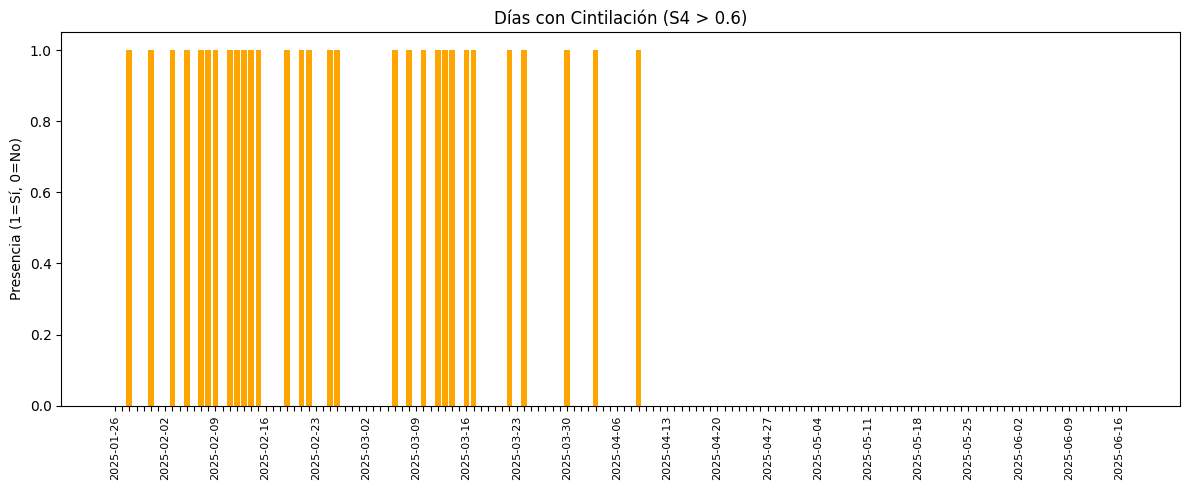


⚙️ Generando características temporales (Sin/Cos)...


In [16]:
if __name__ == "__main__":

    # 1. Configuración
    RUTA            = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook"
    RUTA_DRIVE      = "/content/drive/MyDrive/MAESTRIA_ARTICULO_2026/data"
    RUTA_DRIVE_HYO  = "/content/drive/MyDrive/MAESTRIA_MCC_2024_2/PROCIENCIA_TESIS/DATA_2023_2025_PROC"
    ARCHIVO         = "df_FINAL.csv"
    ARCHIVO_HYO     = "df_FINAL_HUANCAYO.csv"

    # Definición de Features para el modelo (Orden Importante)
    FEATURES_COLS = [
        'S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index',
        'Hora_Sin', 'Hora_Cos'
    ]

    # Parámetros Temporales
    LOOKBACK_MIN = 60
    HORIZON_MIN  = 10
    LOOKBACK_OPTS = [ 60]
    HORIZON_OPTS = [10]

    # 2. Pipeline de ejecución
    # Cargar
    #df_raw = cargar_dataset(RUTA, ARCHIVO)
    #df_raw = cargar_dataset(RUTA_DRIVE, ARCHIVO)
    df_raw = cargar_dataset(RUTA_DRIVE_HYO, ARCHIVO_HYO)

    # Analizar (No modifica df_raw)
    analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=True)

    # Ingeniería de Features (Modifica df_raw)
    df_features = agregar_caracteristicas_temporales(df_raw)

In [17]:
df_features

,Tiempo,ID_Satelite,Azimuth,Elevacion,is_Outlier,Cintilacion,Fecha,TEC,ROTEC,S4,ROTI,Kp_Index,Dst_Index,ap_Index,f10.7_Index,AE_Index,Hora_Sin,Hora_Cos
0,2025-01-26 00:35:00,205.0,59.0,64.0,False,0.0,2025-01-26,70.689140,-0.012351,0.115,0.010958,3.000000,-1.416667,2.00,165.400000,29.083333,0.152123,0.988362
1,2025-01-26 00:36:00,205.0,59.0,64.0,False,0.0,2025-01-26,70.778647,-0.010967,0.098,0.010961,3.000000,-1.400000,2.00,165.400000,29.000000,0.156434,0.987688
2,2025-01-26 00:37:00,205.0,59.0,64.0,False,0.0,2025-01-26,70.868153,-0.009583,0.123,0.010964,3.000000,-1.383333,2.00,165.400000,28.916667,0.160743,0.986996
3,2025-01-26 00:38:00,205.0,59.0,64.0,False,0.0,2025-01-26,70.957660,-0.008198,0.160,0.010966,3.000000,-1.366667,2.00,165.400000,28.833333,0.165048,0.986286
4,2025-01-26 00:39:00,205.0,59.0,64.0,False,0.0,2025-01-26,71.047166,-0.006814,0.136,0.010969,3.000000,-1.350000,2.00,165.400000,28.750000,0.169350,0.985556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199574,2025-06-17 23:11:00,135.0,280.0,32.0,False,0.0,2025-06-17,41.593749,0.000636,0.065,0.000723,24.833333,-6.016667,10.65,143.278333,9999.000000,-0.212178,0.977231
199575,2025-06-17 23:12:00,104.0,327.0,35.0,False,0.0,2025-06-17,41.587333,0.000450,0.076,0.000719,25.000000,-6.200000,10.80,143.240000,9999.000000,-0.207912,0.978148
199576,2025-06-17 23:13:00,104.0,327.0,35.0,False,0.0,2025-06-17,41.580917,0.000264,0.097,0.000716,25.166667,-6.383333,10.95,143.201667,9999.000000,-0.203642,0.979045
199577,2025-06-17 23:14:00,135.0,280.0,32.0,False,0.0,2025-06-17,41.574501,0.000079,0.064,0.000712,25.333333,-6.566667,11.10,143.163333,9999.000000,-0.199368,0.979925


In [18]:
# Estructura Final (Listo para LSTM)
df_final = finalizar_estructura_df(df_features, target_col="S4")
# Visualización rápida de las primeras filas del resultado final
print("\n--- PRIMERAS 5 FILAS DEL DF FINAL ---")
print(df_final.head())

# --- NUEVO PASO: DIVISIÓN ESTRATIFICADA ---
train_df, val_df, test_df = dividir_estratificado_por_dias(df_final, umbral_s4=0.6)

# Auditoría de la división
print("\n=== AUDITORÍA DE DISTRIBUCIÓN DE DATOS ===")
auditar_division_datos(train_df, "Train Set")
auditar_division_datos(val_df, "Validation Set")
auditar_division_datos(test_df, "Test Set")


🧹 Finalizando estructura del DataFrame...
   Columnas eliminadas: ['Fecha', 'Cintilacion']
✅ DataFrame Final Listo. Shape: (199579, 15)
   Columnas finales: ['ID_Satelite', 'Azimuth', 'Elevacion', 'is_Outlier', 'TEC', 'ROTEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'ap_Index', 'f10.7_Index', 'AE_Index', 'Hora_Sin', 'Hora_Cos', 'S4']

--- PRIMERAS 5 FILAS DEL DF FINAL ---
                     ID_Satelite  Azimuth  Elevacion  is_Outlier        TEC  \
Tiempo                                                                        
2025-01-26 00:35:00        205.0     59.0       64.0       False  70.689140   
2025-01-26 00:36:00        205.0     59.0       64.0       False  70.778647   
2025-01-26 00:37:00        205.0     59.0       64.0       False  70.868153   
2025-01-26 00:38:00        205.0     59.0       64.0       False  70.957660   
2025-01-26 00:39:00        205.0     59.0       64.0       False  71.047166   

                        ROTEC      ROTI  Kp_Index  Dst_Index  ap_Index  \
Tie

In [19]:
# --- NUEVO PASO: NORMALIZACIÓN ---
train_scaled, val_scaled, test_scaled, scaler = normalizar_sets(
    train_df, val_df, test_df, FEATURES_COLS
)

# Ejemplo de datos escalados
print("\n--- EJEMPLO DE DATOS ESCALADOS (TRAIN) ---")
print(train_scaled[['Hora_Sin', 'Hora_Cos', 'S4']].head(3))


⚖️ Ejecutando Normalización (MinMaxScaler 0-1)...
   -> Normalizando Train (Fit & Transform)
   -> Normalizando Val (Transform only)
   -> Normalizando Test (Transform only)
   ✅ Normalización completada.
   Rango S4 Original (Train): 0.0210 a 1.3670
   Rango S4 Escalado (Train): 0.0000 a 1.0000

--- EJEMPLO DE DATOS ESCALADOS (TRAIN) ---
                     Hora_Sin  Hora_Cos        S4
Tiempo                                           
2025-01-26 00:35:00  0.576062  0.994185  0.069837
2025-01-26 00:36:00  0.578217  0.993849  0.057207
2025-01-26 00:37:00  0.580371  0.993503  0.075780


In [20]:
# 3. EJECUTAR EXPERIMENTO
df_resultados,diccionario_datos = ejecutar_experimento_iterativo_multistep(
        train_scaled, val_scaled, test_scaled,
        FEATURES_COLS, scaler,
        LOOKBACK_OPTS, HORIZON_OPTS)


🧪 INICIANDO EXPERIMENTO ITERATIVO MULTI-STEP (1 Combinaciones)...
   Lookbacks: [60]
   Horizons:  [10]
   🔥 Ahora cada y contiene SECUENCIAS completas

📏 Cálculo de Umbral Normalizado:
   S4 Real: 0.6  =>  S4 Norm: 0.4302

🔄 [1/1] Probando: Lookback=60 min, Horizon=10 min

🎞️ Generando Ventanas Deslizantes MULTI-STEP (Lookback=60, Horizon=10)...
   Features (9): ['S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 'Hora_Sin', 'Hora_Cos']
   ⚡ Output esperado: SECUENCIAS de 10 valores futuros
   ✅ TRAIN generado. X: (55854, 60, 9), y: (55854, 10)
   ✅ VAL generado.   X: (10472, 60, 9), y: (10472, 10)
   ✅ TEST generado.  X: (13559, 60, 9), y: (13559, 10)

--- DIMENSIONES FINALES (Tensor Shapes) ---
   X_train: (55854, 60, 9)  (muestras, lookback, features)
   y_train: (55854, 10)  (muestras, horizon) ← SECUENCIAS

🧠 Modelo LSTM Multi-Step Compilado:
   Input:  (60, 9)
   Output: 10 valores futuros


Model: "LSTM_MultiStep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       141,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,130 (1.27 MB)

 Trainable params: 332,106 (1.27 MB)

 Non-trainable params: 1,024 (4.00 KB)


🚀 Iniciando entrenamiento Multi-Step...
Epoch 1/30
871/873 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6611 - mae: 0.4433 - root_mean_squared_error: 0.5760
Epoch 1: val_loss improved from inf to 0.00770, saving model to modelo_s4_lstm_multistep_mejor.keras
873/873 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - loss: 0.6597 - mae: 0.4429 - root_mean_squared_error: 0.5756 - val_loss: 0.0077 - val_mae: 0.1265 - val_root_mean_squared_error: 0.1590 - learning_rate: 0.0010
Epoch 2/30
872/873 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0292 - mae: 0.2105 - root_mean_squared_error: 0.2666
Epoch 2: val_loss improved from 0.00770 to 0.00297, saving model to modelo_s4_lstm_multistep_mejor.keras
873/873 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0292 - mae: 0.2104 - root_mean_squared_error: 0.2665 - val_loss: 0.0030 - val_mae: 0.0845 - val_root_mean_squared_error: 0.1096 - learning_rate: 0.0010
Epoch 3/30
871/873 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0108 - mae: 0.1576 - root_mean_squared_error: 0.


📈 Generando Gráfico para: Lookback 60 | Horizon 10


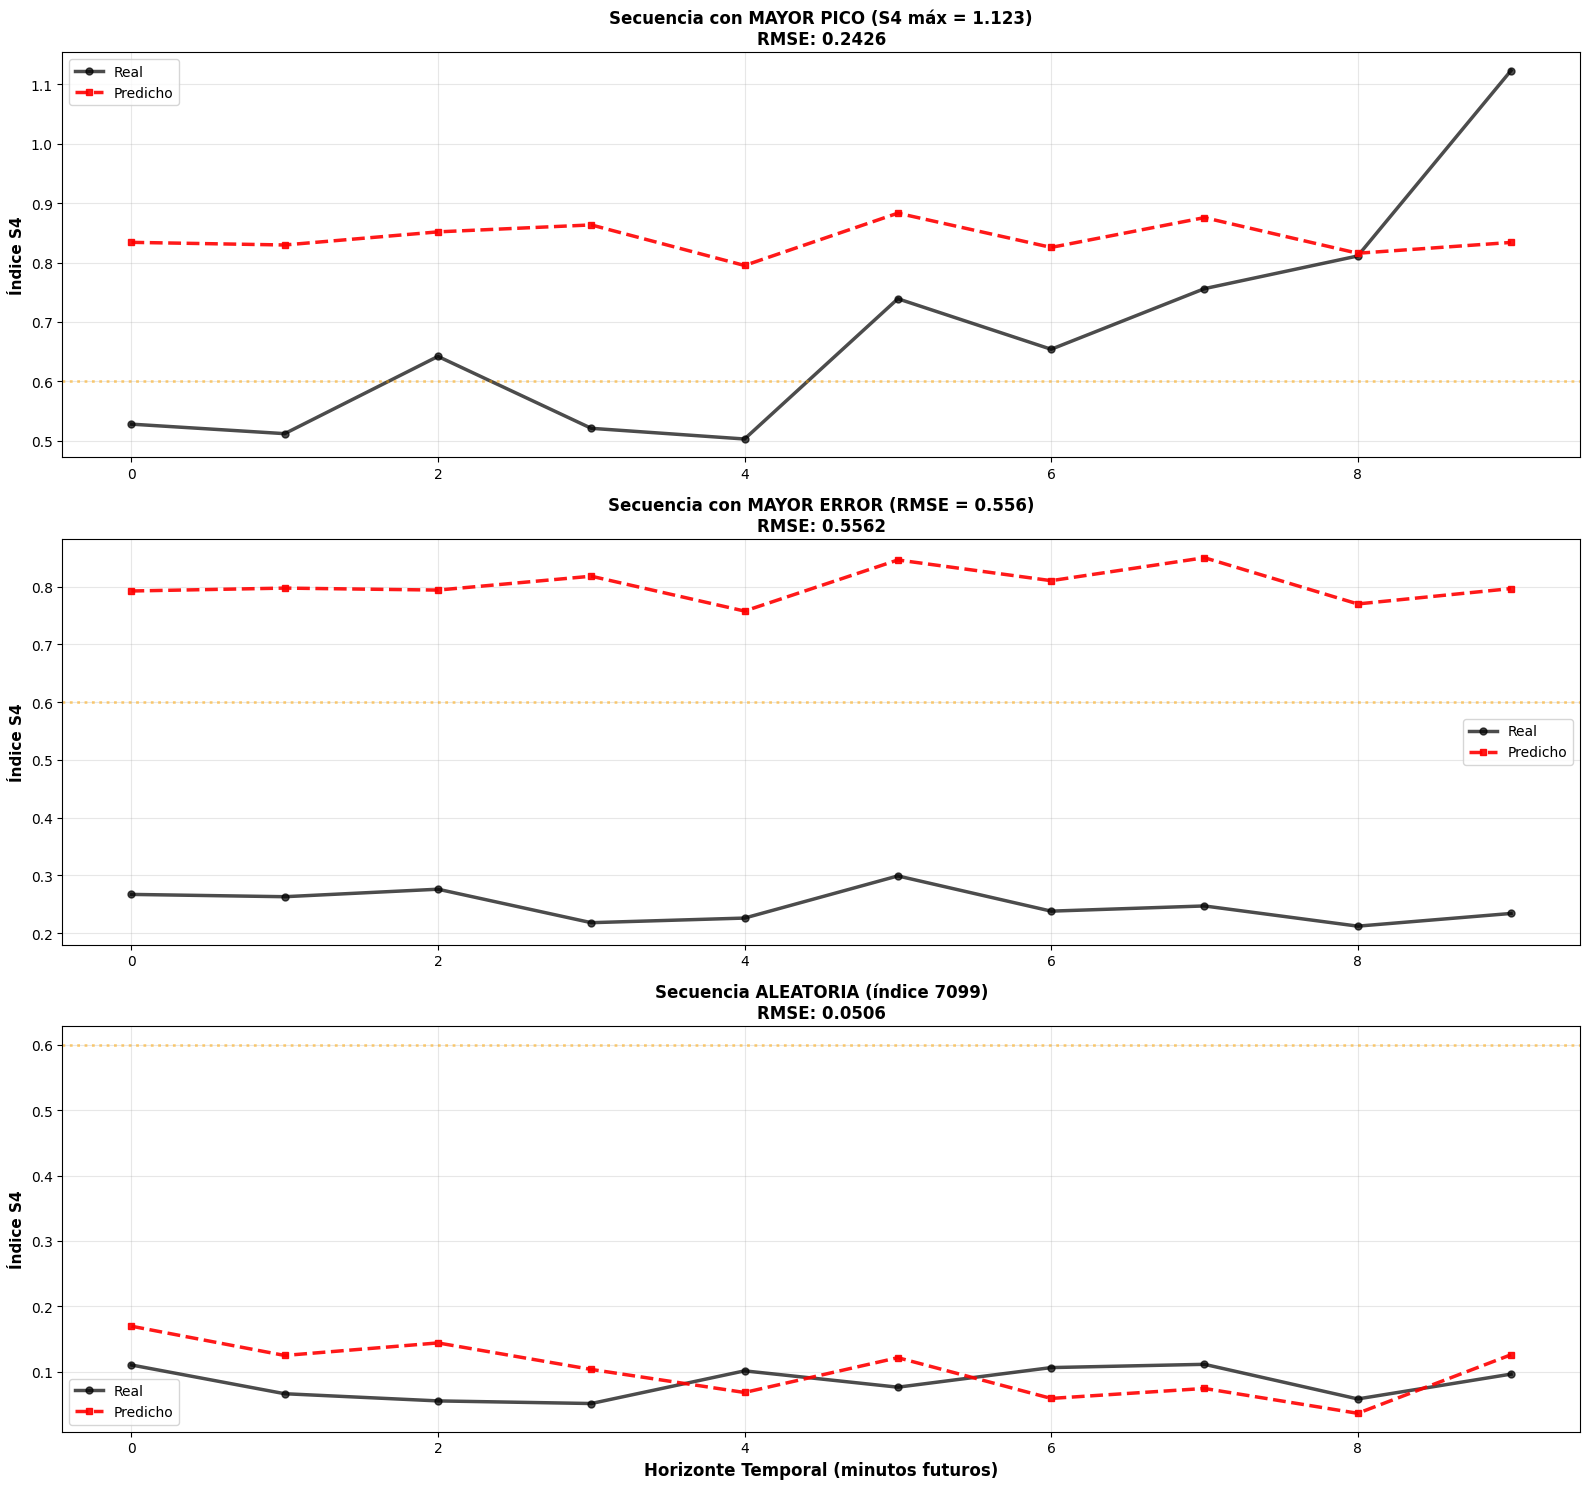

In [23]:
# --- NUEVA ETAPA: REPORTE Y VISUALIZACIÓN ---
# Ejemplo: Quiero ver el gráfico de Lookback=20 y Horizon=5
graficar_resultados_almacenados(diccionario_datos, lookback_deseado=LOOKBACK_OPTS[0], horizon_deseado=HORIZON_OPTS[0])


📊 GRAFICANDO: Lookback=60 | Horizon=10 | Paso Futuro=1
------------------------------------------------------------


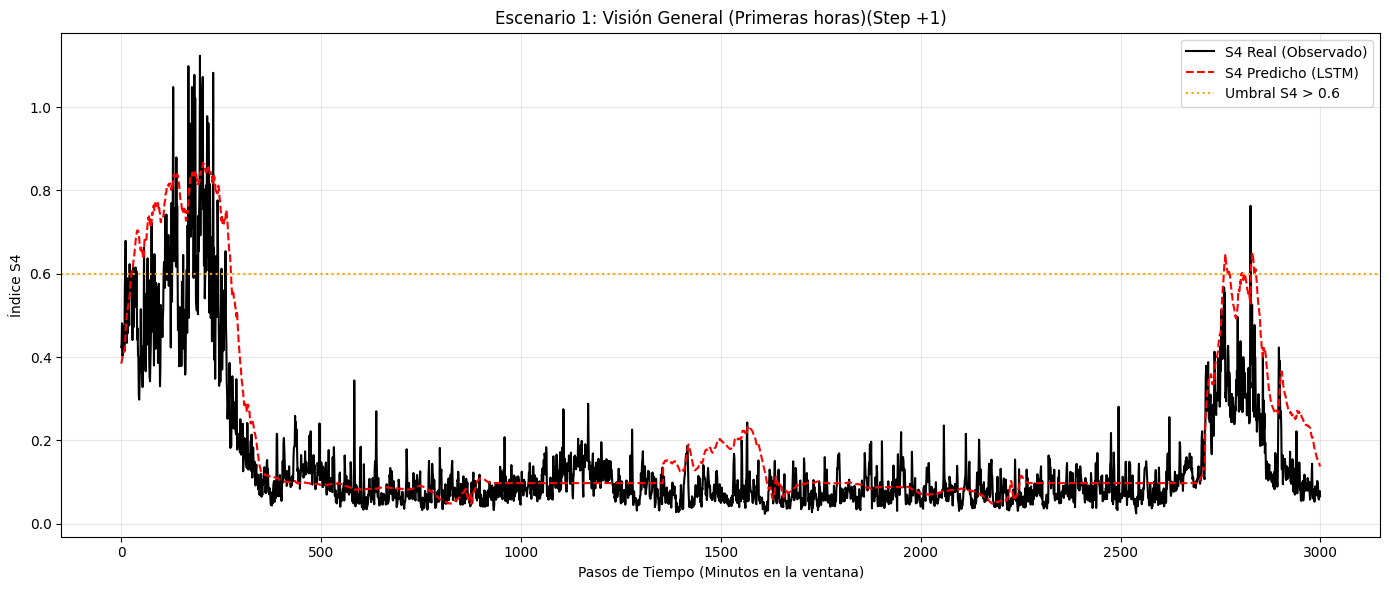


🔎 Buscando la tormenta más fuerte... Pico detectado: 1.123 en índice 197


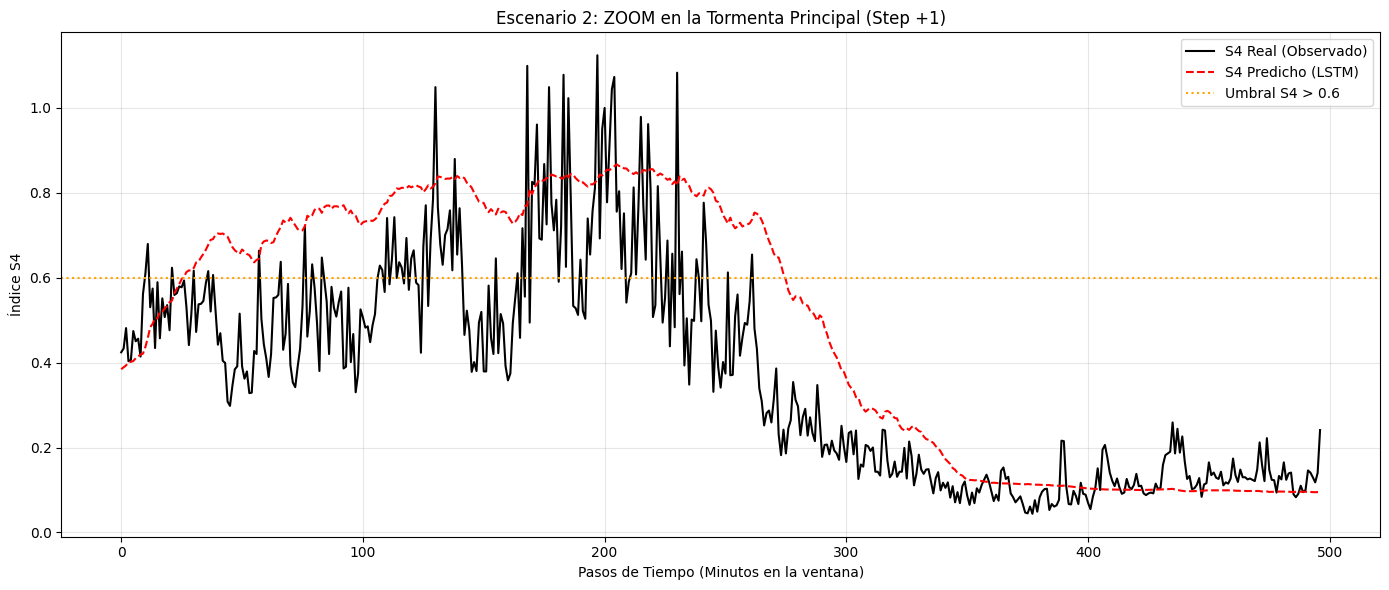

In [24]:
# -------------------------------------------------------
# EJEMPLO DE USO (Post-Entrenamiento)
# -------------------------------------------------------

# 1. Supongamos que el mejor modelo fue Lookback=60, Horizon=30.
# Queremos ver qué tal predice el SIGUIENTE minuto (t+1):
consultar_graficos_almacenados(
    diccionario_datos,
    lb=60,
    hz=10,
    step_idx=0  # <--- Ver predicción inmediata
)

---

# **COMPARACION DE MODELOS SIMPLE,STACKED Y BIDIRECCIONAL**

# **LSTM SIMPLE**

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def construir_modelo_lstm_simple_optimizado(input_shape, output_steps,learning_rate=0.001, **kwargs):
    """
    Arquitectura 1 (Optimizada): Modelo LSTM de un solo nivel.
    Mantiene la simplicidad (1 sola LSTM) pero agrega
    capas de post-procesamiento para mejorar la predicción.
    """
    tf.keras.backend.clear_session()

    model = Sequential([
        Input(shape=input_shape),

        # 1. EL CORAZÓN DEL MODELO (Mantenemos una sola LSTM)
        # return_sequences=False porque ya no hay más capas LSTM después.
        LSTM(64, activation='tanh', return_sequences=False),

        # 2. TUS MEJORAS (Sin agregar otra LSTM)
        # Dropout: Apaga el 20% de neuronas para evitar memorizar ruido.
        Dropout(0.2),

        # Dense(32): "Piensa" y procesa lo que extrajo la LSTM antes de dar el resultado.
        Dense(32, activation='relu'),

        # 3. SALIDA FINAL
        Dense(output_steps, activation='linear')
    ], name="LSTM_Simple_Optimizada")
    # Usamos el learning_rate recibido
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    return model

#**LSTM STACKED**

In [26]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

def construir_modelo_lstm_stacked(input_shape, output_steps,learning_rate=0.001, **kwargs):
    """
    Arquitectura 2: Stacked LSTM (Apilada).
    Mayor profundidad para aprender jerarquías temporales sin la
    complejidad computacional de la bidireccionalidad.
    """
    tf.keras.backend.clear_session()

    model = Sequential([
        Input(shape=input_shape),

        # Capa 1: Pasa la secuencia completa a la siguiente capa
        LSTM(128, activation='tanh', return_sequences=True),
        Dropout(0.2), # Regularización leve

        # Capa 2: Comprime la secuencia en un vector de contexto
        LSTM(64, activation='tanh', return_sequences=False),
        Dropout(0.2),

        # Capa Dense intermedia para refinamiento
        Dense(32, activation='relu'),

        # Salida
        Dense(output_steps, activation='linear')
    ], name="LSTM_Stacked")
    # Usamos el learning_rate recibido
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

#**LSTM BIDIRECCIONAL**

In [27]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization

def construir_modelo_lstm_bidireccional(input_shape, output_steps,learning_rate=0.001, umbral_norm=None, penalty=15.0):
    """
    Arquitectura 3 (Nueva): Bidirectional Deep LSTM.
    Tu arquitectura original optimizada para contexto complejo y regularización.
    """
    tf.keras.backend.clear_session()

    model = Sequential([
        Input(shape=input_shape),

        # Encoder Bidireccional 1: Contexto amplio
        Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),

        # Encoder Bidireccional 2: Compresión de características
        Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),

        # Decoder / Cabezal de predicción
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu'),

        # Salida Multi-step
        Dense(output_steps, activation='linear')
    ], name="LSTM_Bidireccional_Complex")
    # Usamos el learning_rate recibido
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model


# **EJECUTAR BENCHMARK MODELOS**

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

def ejecutar_benchmark_modelos(train_s, val_s, test_s, features_cols, scaler,
                               lookback_fijo, horizon_fijo, modelos_dict,
                               learning_rate=0.001): # <--- NUEVO PARAMETRO
    """
    Compara múltiples arquitecturas de modelos manteniendo fijos los datos (Lookback/Horizon).

    Args:
        modelos_dict: Diccionario { "NombreModelo": funcion_constructora }
                      Ej: {"Simple": construir_modelo_lstm_simple, "Stacked": ...}
    """
    resultados = []
    almacen_predicciones = {}

    print(f"\n🏆 INICIANDO BENCHMARK DE MODELOS")
    print(f"   Configuración Fija: Lookback={lookback_fijo}, Horizon={horizon_fijo}")
    print(f"   Modelos a evaluar: {list(modelos_dict.keys())}")
    print("="*70)

    # 1. Generar datos UNA SOLA VEZ (Igualdad de condiciones)
    # -------------------------------------------------------
    X_train, y_train, X_val, y_val, X_test, y_test = generar_tensores_multistep(
        train_s, val_s, test_s, features_cols,
        target_col='S4', lookback=lookback_fijo, horizon=horizon_fijo
    )

    # Calcular umbral normalizado (necesario para la loss function personalizada si se usa)
    umbral_norm = calcular_umbral_normalizado(scaler, features_cols, umbral_real=0.6)
    input_shape = (X_train.shape[1], X_train.shape[2])
    output_steps = horizon_fijo

    # 2. Iterar sobre cada Arquitectura
    # -------------------------------------------------------
    for nombre_modelo, funcion_constructora in modelos_dict.items():
        print(f"\n🤖 Entrenando arquitectura: {nombre_modelo.upper()}...")

        # A. Construir
        # Nota: Adaptamos la llamada según si la función acepta o no penalty/umbral.
        # Asumimos que tus funciones siguen la firma: (input_shape, output_steps, [opcionales])
        try:
            # Intenta pasar argumentos extra si es el modelo complejo
            model = funcion_constructora(input_shape, output_steps,learning_rate, umbral_norm=umbral_norm, penalty=45.0)
        except TypeError:
            # Si falla (ej. el modelo simple no usa penalty), usa la firma básica
            model = funcion_constructora(input_shape, output_steps)

        # B. Entrenar
        history, _ = entrenar_modelo_multistep(
            model,
            X_train.astype('float32'), y_train.astype('float32'),
            X_val.astype('float32'), y_val.astype('float32'),
            batch_size=64, epochs=30  # Mismas épocas para todos
        )

        # C. Evaluar
        y_pred, y_real = evaluar_predicciones_multistep(
            model, X_test, y_test, scaler, features_cols
        )

        # D. Guardar Predicciones para graficar luego
        almacen_predicciones[nombre_modelo] = {
            "y_real": y_real, # Guardamos real también por seguridad
            "y_pred": y_pred
        }

        # E. Calcular Métricas
        metricas = calcular_metricas_multistep(y_real, y_pred, umbral_evento=0.6)

        registro = {
            "Modelo": nombre_modelo,
            **metricas
        }
        resultados.append(registro)

        print(f"   📊 {nombre_modelo}: Event RMSE={metricas['Event_RMSE']:.4f} | Global RMSE={metricas['Global_RMSE']:.4f}")

    return pd.DataFrame(resultados), almacen_predicciones

#**GRAFICA COMPARATIVA DE MODELOS**

In [30]:
def graficar_comparativa_modelos(df_resultados, almacen_predicciones, umbral_tormenta=0.6):
    """
    Genera un dashboard visual comparativo de los modelos.

    1. Tabla de métricas
    2. Barras comparativas
    3. Serie Temporal Completa
    4. Zooms automáticos en tormentas
    5. Distribución de errores
    """
    modelos = df_resultados['Modelo'].unique()
    colores = sns.color_palette("husl", len(modelos))
    color_map = dict(zip(modelos, colores))

    # Extraer y_real (asumimos que es igual para todos, tomamos el del primer modelo)
    primer_modelo = modelos[0]
    y_real_plot = almacen_predicciones[primer_modelo]['y_real']

    # ==========================================
    # 1. TABLA Y BARRAS
    # ==========================================
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2) # Grilla de 3 filas x 2 columnas

    # A. Gráfica de Barras (RMSE Global vs Evento)
    ax1 = fig.add_subplot(gs[0, :])
    df_melt = df_resultados.melt(id_vars="Modelo", value_vars=["Global_RMSE", "Event_RMSE"], var_name="Metrica", value_name="Error")

    sns.barplot(data=df_melt, x="Modelo", y="Error", hue="Metrica", palette="viridis", ax=ax1)
    ax1.set_title("Comparativa de Error (Menos es mejor)", fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # ==========================================
    # 2. SERIE TEMPORAL COMPLETA
    # ==========================================
    ax2 = fig.add_subplot(gs[1, :])

    # Plot Real
    ax2.plot(y_real_plot, label='REAL', color='black', linewidth=1.5, alpha=0.7)

    # Plot Modelos
    for modelo in modelos:
        y_p = almacen_predicciones[modelo]['y_pred']
        ax2.plot(y_p, label=f'Pred {modelo}', color=color_map[modelo], linewidth=1, alpha=0.8)

    ax2.axhline(umbral_tormenta, color='red', linestyle='--', alpha=0.5, label='Umbral Tormenta')
    ax2.set_title("Serie Temporal Completa: Predicciones vs Realidad", fontsize=12)
    ax2.legend()
    ax2.margins(x=0.01)

    # ==========================================
    # 3. ZOOM EN TORMENTAS (Detectar picos)
    # ==========================================
    ax3 = fig.add_subplot(gs[2, 0])

    # Lógica simple para encontrar una zona interesante (donde real supera el umbral)
    indices_tormenta = np.where(y_real_plot > umbral_tormenta)[0]

    if len(indices_tormenta) > 0:
        # Tomamos el centro de la tormenta más grande o la primera
        idx_centro = indices_tormenta[len(indices_tormenta)//2]
        window_zoom = 100 # 50 pasos antes y 50 despues
        start = max(0, idx_centro - window_zoom)
        end = min(len(y_real_plot), idx_centro + window_zoom)

        ax3.plot(range(start, end), y_real_plot[start:end], color='black', linewidth=2, label='REAL')
        for modelo in modelos:
            y_p = almacen_predicciones[modelo]['y_pred']
            ax3.plot(range(start, end), y_p[start:end], color=color_map[modelo], linewidth=1.5, label=modelo)

        ax3.set_title(f"🔍 ZOOM: Detalle de Tormenta (t={start} a t={end})", fontsize=12)
        ax3.axhline(umbral_tormenta, color='red', linestyle='--')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, "No se detectaron tormentas > umbral", ha='center')

    # ==========================================
    # 4. DISTRIBUCIÓN DE ERRORES (Residuales)
    # ==========================================
    ax4 = fig.add_subplot(gs[2, 1])

    for modelo in modelos:
        y_p = almacen_predicciones[modelo]['y_pred']
        # Error = Pred - Real
        residuales = y_p - y_real_plot
        sns.kdeplot(residuales, label=modelo, color=color_map[modelo], fill=True, alpha=0.1, ax=ax4)

    ax4.axvline(0, color='black', linestyle='--')
    ax4.set_title("Distribución de Errores (Centrado en 0 es mejor)", fontsize=12)
    ax4.set_xlabel("Error (Pred - Real)")
    ax4.legend()

    plt.tight_layout()
    plt.show()

    # Imprimir Tabla formateada
    print("\n📋 TABLA RESUMEN DE MÉTRICAS:")
    print(df_resultados.sort_values("Event_RMSE").to_markdown(index=False))

# **EJECUCION Y PRUEBAS**


🏆 INICIANDO BENCHMARK DE MODELOS
   Configuración Fija: Lookback=60, Horizon=10
   Modelos a evaluar: ['Simple_Optimizado', 'Stacked', 'Bidireccional']

🎞️ Generando Ventanas Deslizantes MULTI-STEP (Lookback=60, Horizon=10)...
   Features (9): ['S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 'Hora_Sin', 'Hora_Cos']
   ⚡ Output esperado: SECUENCIAS de 10 valores futuros
   ✅ TRAIN generado. X: (55854, 60, 9), y: (55854, 10)
   ✅ VAL generado.   X: (10472, 60, 9), y: (10472, 10)
   ✅ TEST generado.  X: (13559, 60, 9), y: (13559, 10)

--- DIMENSIONES FINALES (Tensor Shapes) ---
   X_train: (55854, 60, 9)  (muestras, lookback, features)
   y_train: (55854, 10)  (muestras, horizon) ← SECUENCIAS

📏 Cálculo de Umbral Normalizado:
   S4 Real: 0.6  =>  S4 Norm: 0.4302

🤖 Entrenando arquitectura: SIMPLE_OPTIMIZADO...

🚀 Iniciando entrenamiento Multi-Step...
Epoch 1/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mae: 0.0380
Epoch 1: val_loss improved from i

/tmp/ipython-input-71094475.py:94: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-71094475.py:94: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


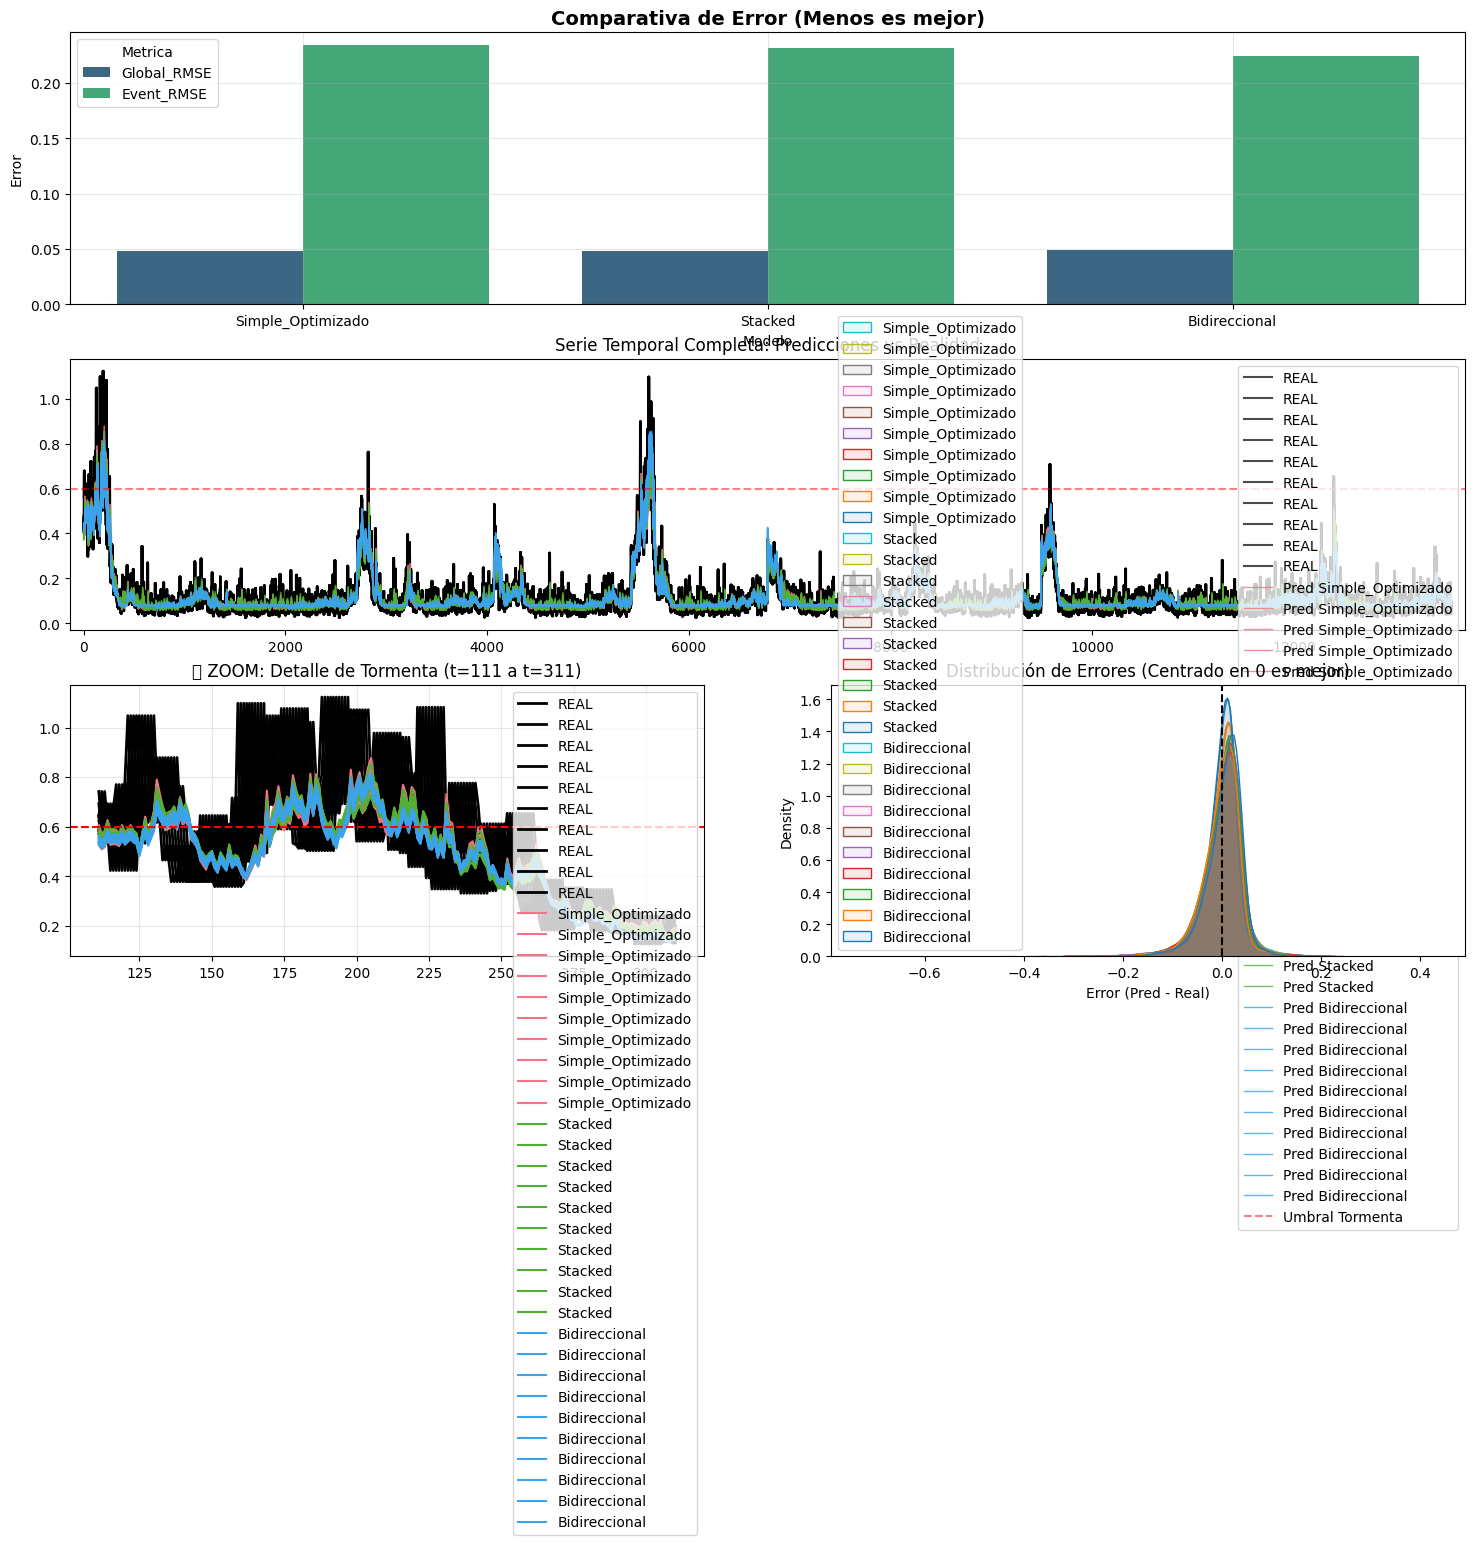


📋 TABLA RESUMEN DE MÉTRICAS:
| Modelo            |   Global_RMSE |   Global_MAE |   Event_RMSE |   Event_MAE |
|:------------------|--------------:|-------------:|-------------:|------------:|
| Bidireccional     |     0.0488815 |    0.0320025 |     0.223998 |    0.179817 |
| Stacked           |     0.0478903 |    0.0308899 |     0.231958 |    0.190651 |
| Simple_Optimizado |     0.0480886 |    0.0310878 |     0.233869 |    0.192287 |


In [31]:
# 1. Definir el diccionario de competidores
modelos_a_comparar = {
    "Simple_Optimizado": construir_modelo_lstm_simple_optimizado, # La que definimos antes
    "Stacked": construir_modelo_lstm_stacked,                     # La intermedia
    "Bidireccional": construir_modelo_lstm_bidireccional          # La compleja original
}

# 2. Elegir la mejor configuración de datos (Previamente descubierta)
BEST_LOOKBACK = 60  # Ejemplo: Cambia esto por tu mejor resultado previo
BEST_HORIZON = 10   # Ejemplo

# 3. Ejecutar Benchmark
#train_scaled, val_scaled, test_scaled, scaler
df_bench, preds_bench = ejecutar_benchmark_modelos(
    train_s=train_scaled,
    val_s=val_scaled,
    test_s=test_scaled,
    features_cols=FEATURES_COLS,
    scaler=scaler,
    lookback_fijo=BEST_LOOKBACK,
    horizon_fijo=BEST_HORIZON,
    modelos_dict=modelos_a_comparar,
    learning_rate=0.0005  # <--- NUEVO PARAMETRO
)

# 4. Graficar Resultados
graficar_comparativa_modelos(df_bench, preds_bench, umbral_tormenta=0.6)